In [372]:
import os
import cv2
from cv2 import solvePnPRansac, Rodrigues
import json
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
import h5py
import pymesh
import tqdm
import pandas as pd

import mmcv
from mmcv import Config
from mmpose.datasets import build_dataset

In [2]:
camera_intrinsics = np.array([[2004.2949249780754, 0, 600],
[0, 2004.2949249780754, 600],
[0, 0, 1]])

In [3]:
data_root = "/pub1/data/keypoint_previous_version_backups/keypoint_v2"

In [59]:
keypts_info_file = f"/pub1/ezzeng/models_ifl_v1/000/textured.obj.hdf5"
with h5py.File(keypts_info_file, "r") as f:
    keypts_0 = f["keypts"]["byhand"][:, 1:]
keypts_info_file = f"/pub1/ezzeng/models_ifl_v1/008/textured.obj.hdf5"
with h5py.File(keypts_info_file, "r") as f:
    keypts_8 = f["keypts"]["byhand"][:, 1:]

In [60]:
obj_0 = pymesh.load_mesh("/pub1/ezzeng/models_ifl_v1/000/textured.obj")
obj_8 = pymesh.load_mesh("/pub1/ezzeng/models_ifl_v1/008/textured.obj")

In [188]:
def parse_scene_info(scene_info_file):
    """from a scene_info json file, generate a pandas dataframe
    with all the category counts in columns

    Args:
        scene_info_file (str): path to scene_info.json file

    Returns:
        pd.DataFrame: pandas dataframe with all category counts in columns
    """
    with open(scene_info_file) as f:
        scene_info = json.load(f)

    scene_info = pd.DataFrame(scene_info['scene_info'])
    category_counts = scene_info['category_counts'].apply(
        lambda x: pd.Series(x, dtype=np.float64))
    category_counts = category_counts.fillna(0)
    category_counts = category_counts.astype(int)

    scene_numbers = scene_info['scene_folder'].str.rsplit(
        "/", 1).str[-1]  # get the basename of of the scene (ie. scene0)
    # remove the first 5 characters of the basename to get only the number
    scene_numbers = scene_numbers.str[5:].astype(int)

    # copy the columns over
    category_counts['scene_numbers'] = scene_numbers
    category_counts['scene_folder'] = scene_info['scene_folder']
    category_counts['view_files'] = scene_info['view_files']
    category_counts = category_counts.set_index('scene_numbers')
    category_counts = category_counts.sort_index()

    return category_counts

In [176]:
def get_keypoints_labels(file_name):
    f = h5py.File(file_name, "r")
    keypts = f["keypts"]
    objects = f["objects"]

    keypoints = []
    
    for i, point in enumerate(keypts["byhand"]["keypts_relative_to_camera"]):
        new_points = np.matmul(camera_intrinsics, point[1:])
        point_2d = new_points[:2] / new_points[2]

        keypoints.append(point_2d)
    if "occluded_keypts_relative_to_camera" in keypts['byhand'].keys():
        for i, point in enumerate(keypts["byhand"]["occluded_keypts_relative_to_camera"]):
            new_points = np.matmul(camera_intrinsics, point[1:])
            point_2d = new_points[:2] / new_points[2]

            keypoints.append(point_2d)
    
    f.close()

    return np.vstack(keypoints)


In [354]:
def transform_3d_points(pose, mesh):
    obj_points = mesh.vertices * 100
    transformed_obj_points = obj_points.dot(pose[:3, :3].T) + pose[:3, 3]
    return transformed_obj_points

def transform_obj_points(pose, mesh):
#     print(pose)
    transformed_obj_points = transform_3d_points(pose, mesh).dot(camera_intrinsics.T)
    transformed_obj_points = np.concatenate([
        np.divide(transformed_obj_points[:, 0], transformed_obj_points[:, 2])[:, None], 
        np.divide(transformed_obj_points[:, 1], transformed_obj_points[:, 2])[:, None]], axis=1)
    
    return transformed_obj_points

In [52]:
def get_transformed_object_points(base_path, cats=[0, 8]):
    hdf5_path = base_path + '_scene.hdf5'
    with h5py.File(hdf5_path, 'r') as f:
        object_categories = f['objects']['categories'][:]
        object_poses = f['objects']['poses_relative_to_camera'][:]
    all_obj_points = []
    
    for category, pose in zip(object_categories, object_poses):
        if int(category) not in cats:
            continue
        category = int(category)
        folder = f"/pub1/ezzeng/models_ifl/{category:03d}"
        
        mesh = pymesh.load_mesh(os.path.join(folder, "textured.obj"))
        
        transformed_obj_points = transform_obj_points(pose, mesh)
        
        all_obj_points.append(transformed_obj_points)
    
    return all_obj_points

In [88]:
def get_result_points(result):
    x_points = np.array(result['keypoints'][::3])[:, None]
    y_points = np.array(result['keypoints'][1::3])[:, None]
    points_2d = np.concatenate([x_points, y_points], axis=1)
    return points_2d

def get_keypoints_pose(points_2d, obj_3d_keypoints):
    retval, rvec, tvec, inliers = solvePnPRansac(obj_3d_keypoints, points_2d, camera_intrinsics, None)
    r_mat = Rodrigues(rvec)

    pose = np.zeros((4, 4))
    pose[:3, :3] = r_mat[0]
    pose[:3, 3] = tvec.T
    pose[3, 3] = 1
    
    return pose

In [547]:
def display_img_result(img_id, show_cats=None):
    filename = dataset.coco.loadImgs(ids=[img_id])[0]['file_name']
    filename = os.path.join(data_root, filename)
    img = plt.imread(filename)
    
    all_obj_points = get_transformed_object_points(filename[:-8])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
#     fig, ax2 = plt.subplots(figsize=(15, 10))
    ax2.axis('off')
    ax1.axis('off')
    ax1.imshow(img)
    for point_cloud in all_obj_points:
        ax1.scatter(point_cloud[:, 0], point_cloud[:, 1], alpha=0.1, s=0.1)
    
    ax2.imshow(img)
    
    
    if show_cats == 8:
        iter_res = zip([keypoints_8_res,], [keypts_8,], [obj_8,])
    elif show_cats == 0:
        iter_res = zip([keypoints_0_res, ], [keypts_0, ], [obj_0, ])
    else:
        iter_res = zip([keypoints_0_res, keypoints_8_res], [keypts_0, keypts_8], [obj_0, obj_8])
    
    
    for coco_res, keypts, obj_mesh in iter_res:
        
        results = coco_res.loadAnns(coco_res.getAnnIds(imgIds=img_id))
        all_points = []
        for result in results:
            points_2d = get_result_points(result)
            
            pose = get_keypoints_pose(points_2d, keypts)
            obj_points_2d = transform_obj_points(pose, obj_mesh)
            
            ax2.scatter(obj_points_2d[:, 0], obj_points_2d[:, 1], alpha=0.1, s=0.1)
            all_points.append(points_2d)
        for points_2d in all_points:
            ax2.scatter(points_2d[:, 0], points_2d[:, 1], s=20)
        
    return fig

In [208]:
def show_img(img_base):
    base_path = os.path.join(data_root, img_base)
    keypoints = get_keypoints_labels(base_path + '_scene.hdf5')
    img = plt.imread(base_path + "_rgb.png")

    fig, ax1 = plt.subplots(1, figsize=(15, 10))
    ax1.axis('off')
    ax1.imshow(img)
    ax1.scatter(keypoints[:, 0], keypoints[:, 1], s=50)

In [403]:
def get_ADD_score(points_2d, gt_pose, obj_mesh, obj_3d_keypoints, proj=False):
    pred_pose = get_keypoints_pose(points_2d, obj_3d_keypoints)
    
    if proj:
        pred_points = transform_obj_points(pred_pose, obj_mesh)
        gt_points = transform_obj_points(gt_pose, obj_mesh)
    else:
        pred_points = transform_3d_points(pred_pose, obj_mesh)
        gt_points = transform_3d_points(gt_pose, obj_mesh)
    
    return np.mean(np.abs(gt_points - pred_points ))

In [538]:
def get_add_scores_img(img_id, cats=[0, 8], proj=False, show_cats=None):
    filename = dataset.coco.loadImgs(ids=[img_id])[0]['file_name']
    filename = os.path.join(data_root, filename)
    img = plt.imread(filename)
    base_path = filename[:-8]
    
    hdf5_path = base_path + '_scene.hdf5'
    with h5py.File(hdf5_path, 'r') as f:
        object_categories = f['objects']['categories'][:]
        object_poses = f['objects']['poses_relative_to_camera'][:]
        
    poses = {cat: [] for cat in cats}
    
    for category, pose in zip(object_categories, object_poses):
        category = int(category)
        if category not in cats:
            continue
        
        poses[category].append(pose)
        
    all_ADD = []
    
   
    if show_cats == 8:
        iter_res = zip([keypoints_8_res,], [keypts_8,], [obj_8,], [poses[8],])
    elif show_cats == 0:
        iter_res = zip([keypoints_0_res, ], [keypts_0, ], [obj_0, ], [poses[0], ])
    else:
        iter_res = zip([keypoints_0_res, keypoints_8_res], [keypts_0, keypts_8], [obj_0, obj_8], [poses[0], poses[8]])
    
    
    for coco_res, keypts, obj_mesh, gt_poses in iter_res:
        
        results = coco_res.loadAnns(coco_res.getAnnIds(imgIds=img_id))
        all_points = []
        for result, gt_pose in zip(results, gt_poses):
            points_2d = get_result_points(result)
            all_ADD.append(get_ADD_score(points_2d, gt_pose, obj_mesh, keypts, proj=proj))
        
    return all_ADD

In [8]:
cfg = Config.fromfile("configs/metagraspnet/res50_coco.py")
cfg.data.test.test_mode = True
dataset = build_dataset(cfg.data.test, dict(test_mode=True))

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
=> num_images: 42535
=> load 3855 samples


In [9]:
keypoints_0_res = dataset.coco.loadRes("work_dirs/res50_coco/result_keypoints_0.json")
keypoints_8_res = dataset.coco.loadRes("work_dirs/res50_coco/result_keypoints_8.json")

Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!


In [137]:
for img_id in tqdm.notebook.tqdm_notebook(dataset.coco.getImgIds(catIds=0)):
    try:
        fig = display_img_result(img_id)
        fig.savefig(f"data/output/pose/{img_id}.png")
        plt.close(fig)
    except KeyError:
        continue
        
for img_id in tqdm.notebook.tqdm_notebook(dataset.coco.getImgIds(catIds=8)):
    try:
        fig = display_img_result(img_id)
        fig.savefig(f"data/output/pose/{img_id}.png")
        plt.close(fig)
    except KeyError:
        continue

  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/2146 [00:00<?, ?it/s]

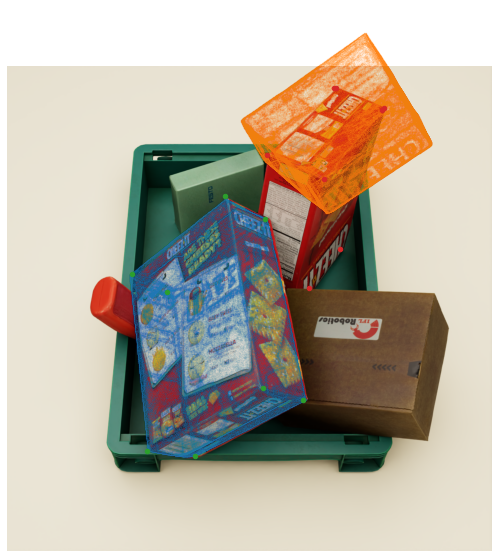

In [356]:
# print(dataset.coco.loadImgs(8894)[0]['file_name'])
fig = display_img_result(24182)

over-reliance on local features - confusion between two objects stacked together

In [482]:
all_add_0 = []
all_add_8 = []
for img_id in tqdm.notebook.tqdm_notebook(dataset.coco.getImgIds(catIds=0)):
    try:
        all_add_0.extend(get_add_scores_img(img_id))
    except KeyError:
        continue
        
for img_id in tqdm.notebook.tqdm_notebook(dataset.coco.getImgIds(catIds=8)):
    try:
        all_add_8.extend(get_add_scores_img(img_id))
    except KeyError:
        continue

  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/2146 [00:00<?, ?it/s]

In [362]:
all_add_0 = np.array(all_add_0)
all_add_8 = np.array(all_add_8)

In [363]:
all_add_0.mean()

2.3061633036369447

In [364]:
all_add_8.mean()

7.890253804997287

In [394]:
def get_acc_plot(all_add_scores, max_thresh, ax, label):
    accuracy_thresholds = np.linspace(0, max_thresh, 20)
    accuracy_scores = np.array([(all_add_scores < thresh).mean() for thresh in accuracy_thresholds])
    ax.plot(accuracy_thresholds, accuracy_scores, label=label)
    

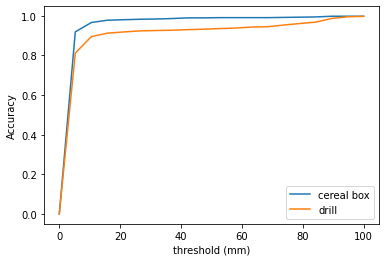

In [396]:
fig, ax = plt.subplots()
get_acc_plot(all_add_0, 100, ax, 'cereal box')
get_acc_plot(all_add_8, 100, ax, 'drill')
ax.set_xlabel("threshold (mm)")
ax.set_ylabel("Accuracy")
plt.legend()

  0%|          | 0/666 [00:00<?, ?it/s]

  0%|          | 0/2146 [00:00<?, ?it/s]

2.3061633036369447
7.890253804997287


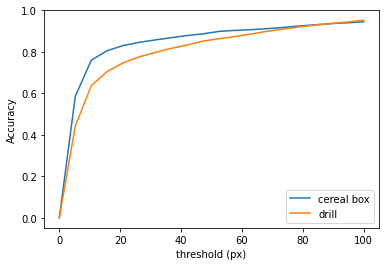

In [404]:
all_add_0_proj = []
all_add_8_proj = []
for img_id in tqdm.notebook.tqdm_notebook(dataset.coco.getImgIds(catIds=0)):
    try:
        all_add_0_proj.extend(get_add_scores_img(img_id, proj=True))
    except KeyError:
        continue
        
for img_id in tqdm.notebook.tqdm_notebook(dataset.coco.getImgIds(catIds=8)):
    try:
        all_add_8_proj.extend(get_add_scores_img(img_id, proj=True))
    except KeyError:
        continue
        
all_add_0_proj = np.array(all_add_0_proj)
all_add_8_proj = np.array(all_add_8_proj)

fig, ax = plt.subplots()
get_acc_plot(all_add_0_proj, 200, ax, 'cereal box')
get_acc_plot(all_add_8_proj, 200, ax, 'drill')
ax.set_xlabel("threshold (px)")
ax.set_ylabel("Accuracy")
plt.legend()

print(all_add_0.mean())
print(all_add_8.mean())

In [409]:
print(all_add_0_proj.max())
print(all_add_8_proj.max())

237.7901927602068
234.2704007506466


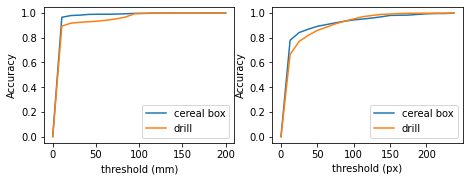

In [566]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 2.5))

get_acc_plot(all_add_0, 200, ax1, 'cereal box')
get_acc_plot(all_add_8, 200, ax1, 'drill')
ax1.set_xlabel("threshold (mm)")
ax1.set_ylabel("Accuracy")
ax1.legend()

get_acc_plot(all_add_0_proj, 238, ax2, 'cereal box')
get_acc_plot(all_add_8_proj, 238, ax2, 'drill')
ax2.set_xlabel("threshold (px)")
ax2.set_ylabel("Accuracy")
ax2.legend()

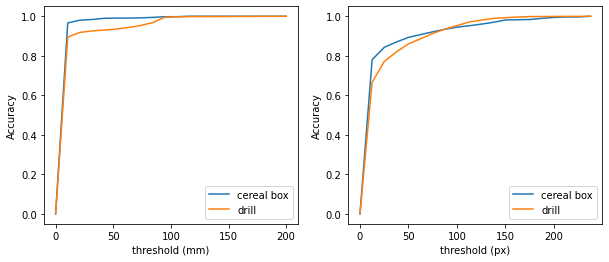

In [570]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

get_acc_plot(all_add_0, 200, ax1, 'cereal box')
get_acc_plot(all_add_8, 200, ax1, 'drill')
ax1.set_xlabel("threshold (mm)")
ax1.set_ylabel("Accuracy")
ax1.legend()

get_acc_plot(all_add_0_proj, 238, ax2, 'cereal box')
get_acc_plot(all_add_8_proj, 238, ax2, 'drill')
ax2.set_xlabel("threshold (px)")
ax2.set_ylabel("Accuracy")
ax2.legend()

In [436]:
img_ids_8 = dataset.coco.getImgIds(catIds=8)
difficulty_8 = np.array(
    [img_info['difficulty'] for img_info in dataset.coco.loadImgs(img_ids_8)]
)
img_ids_8 = np.array(img_ids_8)

all_add_8_test = [[], [], [], [], []]
for difficulty in [1, 2, 3, 4, 5]:
    for img_id in tqdm.notebook.tqdm_notebook(img_ids_8[difficulty_8 == difficulty]):
        try:
            all_add_8_test[difficulty - 1].extend(get_add_scores_img(img_id, proj=True, show_cats=8))
        except KeyError:
            continue
        
all_add_8_test = [np.array(add_err) for add_err in all_add_8_test]

In [548]:
img_ids_0 = keypoints_0_res.getImgIds(catIds=0)

difficulty_0 = np.array(
    [img_info['difficulty'] for img_info in keypoints_0_res.loadImgs(img_ids_0)]
)
img_ids_0 = np.array(img_ids_0)

all_add_0_test = [[], [], [], [], []]
for difficulty in [1, 2, 3, 4, 5]:
    for img_id in tqdm.notebook.tqdm_notebook(img_ids_0[difficulty_0 == difficulty]):
        try:
            all_add_0_test[difficulty - 1].extend(get_add_scores_img(img_id, proj=True, show_cats=0))
        except KeyError:
            print(img_id)
        
all_add_0_test = [np.array(add_err) for add_err in all_add_0_test]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/524 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

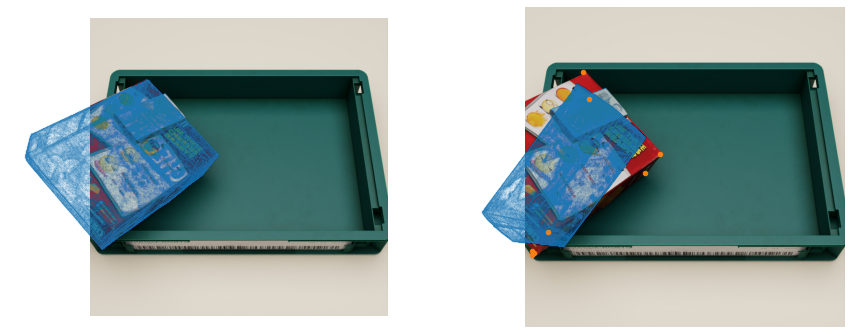

In [549]:
fig = display_img_result(img_ids_0[0])

## da faq...

## Note: bug where categories are confused for each other

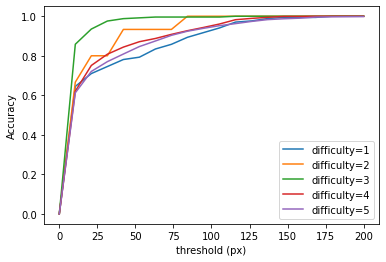

In [484]:
fig, ax = plt.subplots()
for difficulty in [1, 2, 3, 4, 5]:
    get_acc_plot(all_add_8_test[difficulty - 1], 200, ax, f"difficulty={difficulty}")
    
ax.set_xlabel("threshold (px)")
ax.set_ylabel("Accuracy")
plt.legend()

In [533]:
all_add_0_test

[[], [], [], [], []]

/tmp/ipykernel_252465/2906979657.py:3: RuntimeWarning: Mean of empty slice.
  accuracy_scores = np.array([(all_add_scores < thresh).mean() for thresh in accuracy_thresholds])


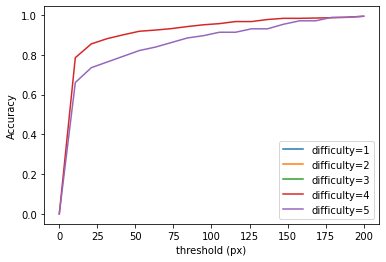

In [550]:
fig, ax = plt.subplots()
for difficulty in [1, 2, 3, 4, 5]:
    get_acc_plot(all_add_0_test[difficulty - 1], 200, ax, f"difficulty={difficulty}")
    
ax.set_xlabel("threshold (px)")
ax.set_ylabel("Accuracy")
plt.legend()

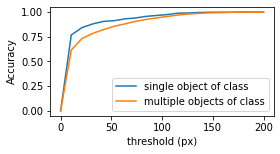

In [555]:
fig, ax = plt.subplots(figsize=(4, 2))

get_acc_plot(np.concatenate(all_add_8_test[:3]), 200, ax, "single object of class")
get_acc_plot(np.concatenate(all_add_8_test[3:]), 200, ax, "multiple objects of class")
    
ax.set_xlabel("threshold (px)")
ax.set_ylabel("Accuracy")
plt.legend()

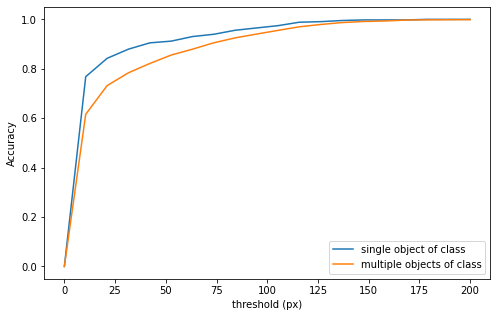

In [572]:
fig, ax = plt.subplots(figsize=(8, 5))

get_acc_plot(np.concatenate(all_add_8_test[:3]), 200, ax, "single object of class")
get_acc_plot(np.concatenate(all_add_8_test[3:]), 200, ax, "multiple objects of class")
    
ax.set_xlabel("threshold (px)")
ax.set_ylabel("Accuracy")
plt.legend()

  0%|          | 0/10 [00:00<?, ?it/s]

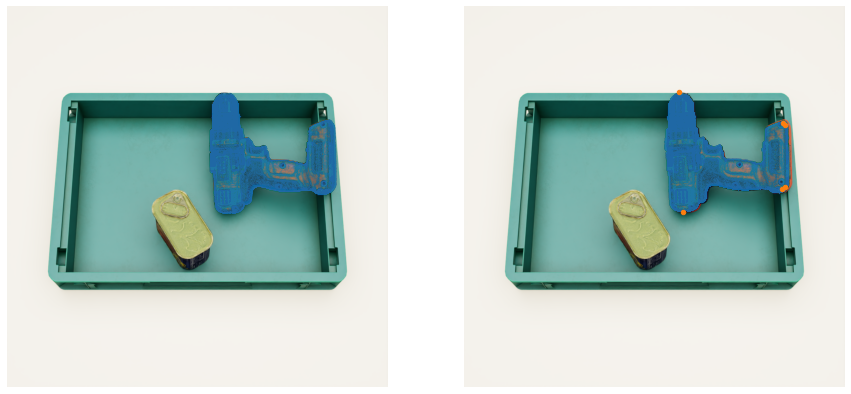

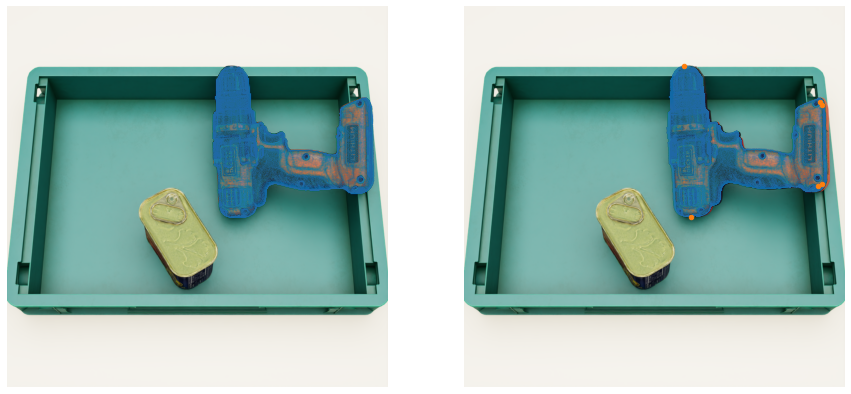

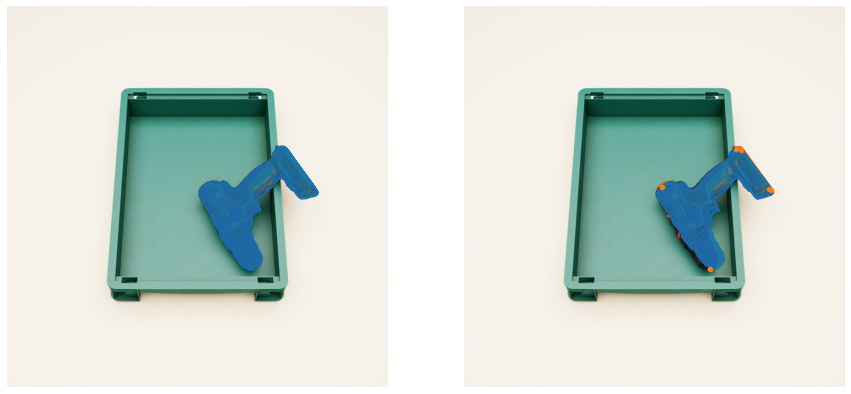

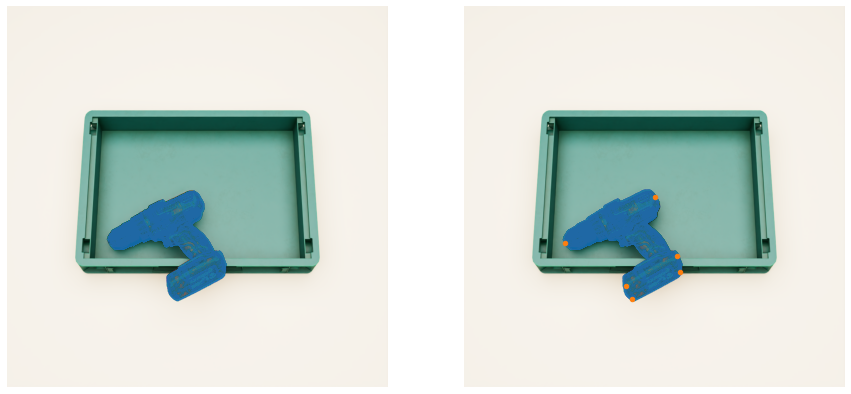

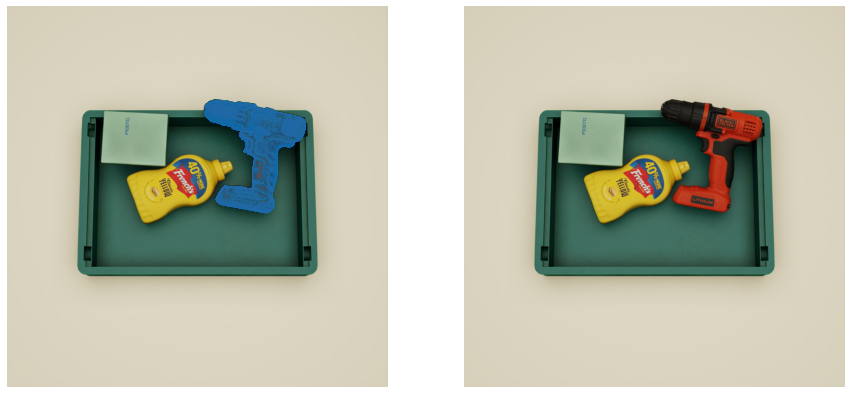

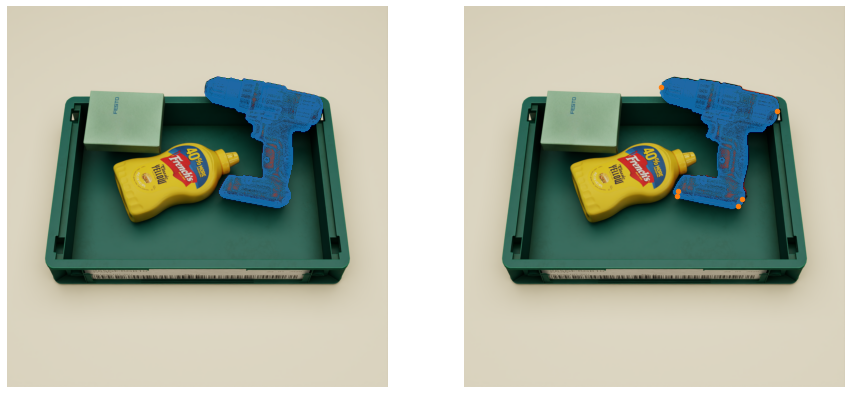

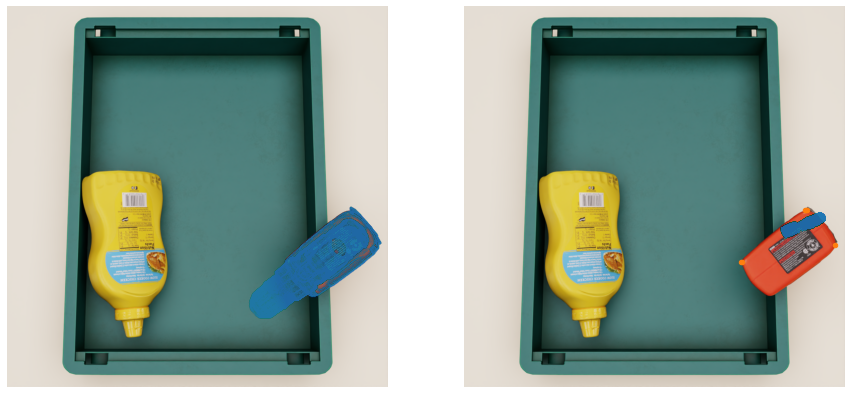

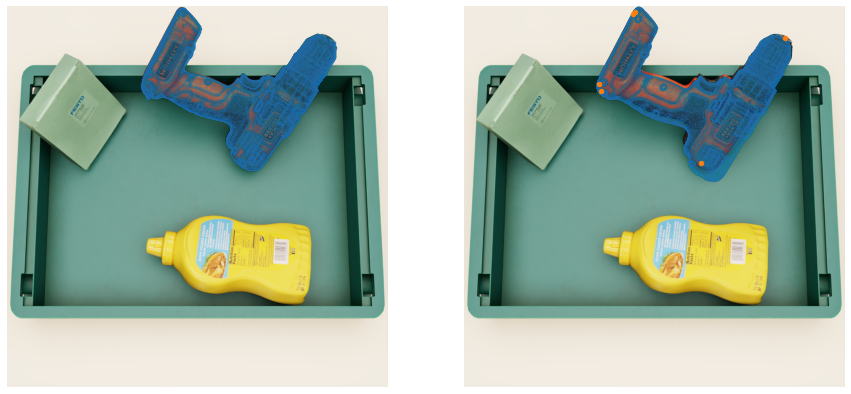

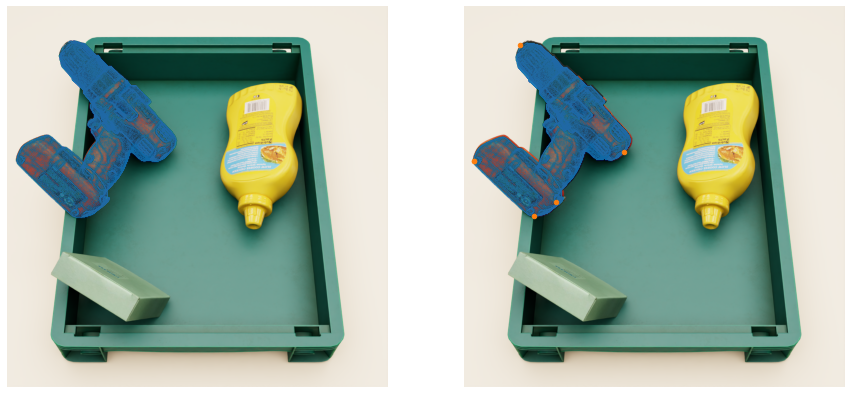

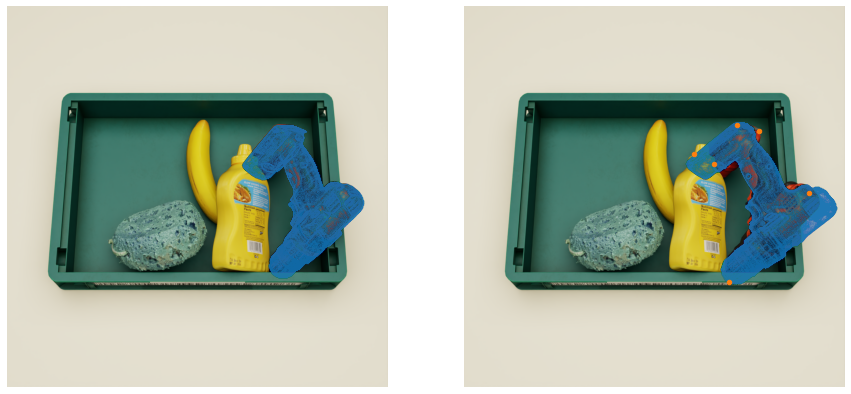

In [462]:
for difficulty in [1]:
    for img_id in tqdm.notebook.tqdm_notebook(img_ids_8[difficulty_8 == difficulty][::20]):
        try:
            fig = display_img_result(img_id, show_cats=8)
        except KeyError:
            continue

In [468]:
img_ids_8[difficulty_8 == 1][::20][4]

27022

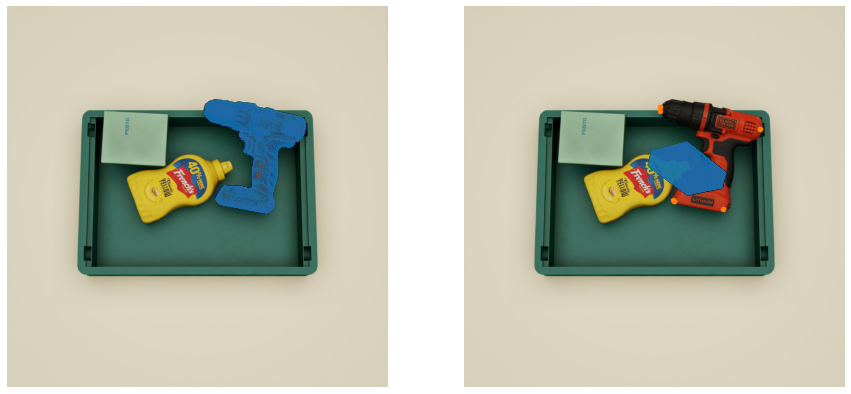

In [470]:
fig = display_img_result(27022)

In [472]:
keypoints_8_res.loadAnns(keypoints_8_res.getAnnIds(imgIds=27022))

[]

In [478]:
keypoints_0_res.loadAnns(keypoints_0_res.getAnnIds(imgIds=27022))[0]['keypoints']

[662.3623046875,
 614.3720703125,
 0.35603904724121094,
 658.8955078125,
 610.9052734375,
 0.3357926905155182,
 932.7724609375,
 385.5634765625,
 0.4989272356033325,
 932.7724609375,
 385.5634765625,
 0.5511379241943359,
 662.3623046875,
 614.3720703125,
 0.5212126970291138,
 818.3681640625,
 638.6396484375,
 0.4775463938713074,
 617.2939453125,
 330.0947265625,
 0.38580626249313354,
 617.2939453125,
 316.2275390625,
 0.6127066612243652]

In [475]:
dataset.coco.loadAnns(dataset.coco.getAnnIds(imgIds=27022))

[{'segmentation': [[654.0,
    293.0,
    653.0,
    294.0,
    651.0,
    294.0,
    650.0,
    295.0,
    649.0,
    295.0,
    648.0,
    296.0,
    646.0,
    296.0,
    645.0,
    297.0,
    644.0,
    297.0,
    643.0,
    298.0,
    639.0,
    298.0,
    638.0,
    299.0,
    637.0,
    299.0,
    636.0,
    300.0,
    635.0,
    300.0,
    634.0,
    301.0,
    633.0,
    301.0,
    633.0,
    302.0,
    632.0,
    303.0,
    631.0,
    303.0,
    629.0,
    305.0,
    628.0,
    305.0,
    627.0,
    306.0,
    626.0,
    306.0,
    624.0,
    308.0,
    624.0,
    309.0,
    623.0,
    310.0,
    623.0,
    311.0,
    622.0,
    312.0,
    622.0,
    315.0,
    621.0,
    316.0,
    621.0,
    319.0,
    620.0,
    320.0,
    620.0,
    333.0,
    619.0,
    334.0,
    619.0,
    337.0,
    620.0,
    338.0,
    620.0,
    339.0,
    621.0,
    339.0,
    624.0,
    342.0,
    624.0,
    345.0,
    629.0,
    350.0,
    630.0,
    350.0,
    631.0,
    351.0,
    631.0,
    3